In [73]:
import numpy as np
import matplotlib.pyplot as plt

Moteur de pricing multilevel monte carlo

In [123]:
from abc import ABC, abstractmethod

from numpy import ndarray

class model(ABC) : 
   @abstractmethod
   def __init__(self,interest_rate : float, initial_value: ndarray) -> None:
      self.dimension = initial_value.shape[0]
      print("dimension : "+str(self.dimension))
      self.initial_value =initial_value
      self.interest_rate = interest_rate

   @abstractmethod
   def drift(self, t : float, x : ndarray)->ndarray:
      pass
   @abstractmethod
   def diffusion(self, t:float,x:ndarray)->ndarray:
      pass
   
class black_sholes(model):
  def __init__(self,initial_value: ndarray,interest_rate : float, sigma: float) -> None:
     super().__init__( interest_rate,initial_value)
     self.sigma = sigma
  
  def drift(self, t : float , x: ndarray) ->ndarray: 
      return self.interest_rate*x
  def diffusion(self, t: float, x: ndarray)->ndarray : 
     return self.sigma*np.diag(x)

class heston(model):
   def __init__(self, initial_value : ndarray, interest_rate: float, sigma : float, lambd: float, ksi : float, rho : float)->None : 
      super().__init__(interest_rate, initial_value)
      self.sigma = sigma
      self.lambd = lambd
      self.ksi = ksi
      self.rho = rho
   
   def drift(self, t : float, x : ndarray)->ndarray : 
      return np.array([self.interest_rate*x[0], self.lambd*(self.sigma**2-x[1])])
   
   def diffusion(self, t : float, x : ndarray)->ndarray : 
      sqV = np.sqrt(np.maximum(x[1],0))
      return np.array([[x[0]*sqV,0],[self.rho*self.ksi*sqV,np.sqrt(1-self.rho**2)*self.ksi*sqV]])

class contract(ABC) :
   @abstractmethod
   def __init__(self, maturity : float) -> None:
      self.maturity = maturity

   @abstractmethod
   def payoff(self, path : np.ndarray)-> ndarray:
      pass

class call(contract):
   #call sur le premier processus de path
   def __init__(self, maturity: float,strike: float) -> None:
      super().__init__(maturity)
      self.strike = strike

   def payoff(self, path: ndarray) -> ndarray:
      return np.maximum(path[:,-1,0]-self.strike,0)
   
class put(contract):
   #put sur le premier processus de path
   def __init__(self, maturity: float,strike: float) -> None:
      super().__init__(maturity)
      self.strike = strike

   def payoff(self, path: ndarray) -> ndarray:
      return np.maximum(self.strike-path[:,-1,0],0)

class asian_call(contract):
   #call asiatique sur le premier processus de path
   def __init__(self, maturity: float,strike: float) -> None:
      super().__init__(maturity)
      self.strike = strike

   def payoff(self, path: ndarray) -> ndarray:
      return np.maximum(np.mean(path[:,:,0],axis=1)-self.strike,0)
   

class asian_put(contract):
   #put asiatique sur le premier processus de path
   def __init__(self, maturity: float,strike: float) -> None:
      super().__init__(maturity)
      self.strike = strike

   def payoff(self, path: ndarray) -> ndarray:
      return np.maximum(self.strike-np.mean(path[:,:,0],axis=1),0)

class digital_option(contract):
   def __init__(self,maturity : float) : 
      super().__init__(maturity)
   def payoff(self, path : ndarray)-> ndarray:
      return np.heaviside(path[:,-1,0]-1,0)

class lookback_option(contract):
   def __init__(self, maturity : float, vol : float):
      super().__init__(maturity)
      self.vol = vol
   def payoff(self, path : ndarray)->ndarray :
      step_size = self.maturity/(path.shape[1]-1)
      correction_term = 1-0.5826*self.vol*np.sqrt(step_size)
      return path[:,-1,0]-np.min(path[:,:,0], axis = 1)*correction_term

class multilevel_mc_estimator : 
    
    def __init__(self, M: int, max_level: int,N_default: int, verbose : bool = False, plot_paths: bool = False) -> None:
      self.verbose = verbose
      self.plot_paths = plot_paths
      self.M = M
      self.max_level = max_level
      self.N_default = N_default
      self.payoffs = []
      self.variances_Yl = []
      self.means_Yl = []

    def compute_mc_estimator(self,model: model, contract:contract,target_error:float,test_type : str)-> float:
        self.model = model
        self.contract = contract
        self.target_error = target_error
        self.test_type = test_type
        self.converged = False
        level = 0

        while not self.converged and level<= self.max_level:
           if self.verbose : 
              print("level : "+str(level))
           self.sample_payoffs(self.N_default,level)
           self.means_Yl.append(np.mean(self.payoffs[level]))
           self.variances_Yl.append(np.var(self.payoffs[level]))
           optimal_Nl = self.compute_optimal_Nl()
           if self.verbose : 
              print("Optimal Nl : "+str(optimal_Nl))
           self.sample_new_payoffs(level,optimal_Nl)
           if level>=2 : 
              self.test_convergence()
           level+=1
        array_means_Yl = np.array(self.means_Yl)
        if self.verbose : 
           print("mean(Y0, ..., YL) = "+str(array_means_Yl))
           print("var(Y0, ... YL) = "+str(self.variances_Yl))
        monte_carlo_estimator  = np.sum(array_means_Yl)
        if self.test_type =="10":
           return(monte_carlo_estimator)  
        elif self.test_type == "11": 
           return monte_carlo_estimator+ array_means_Yl[-1]/(M-1)        

    def test_convergence(self)->None:
       if self.verbose : 
          print("convergence test : ")
       if self.test_type == "10" : 
          self.test_convergence_10()
       if self.test_type == "11" : 
          self.test_convergence_11()
   
    def test_convergence_10(self)->None:
      Yl = self.means_Yl[-1]
      Yl_1 = self.means_Yl[-2]
      if self.verbose : 
         print("error (should be smaller than target error :  "+str(self.target_error)+") : "+str( max(np.abs(Yl),np.abs(Yl_1)/self.M)*np.sqrt(2)/(self.M-1)))
      self.converged =  max(np.abs(Yl),np.abs(Yl_1)/self.M)<(self.M-1)*self.target_error/np.sqrt(2)

    def test_convergence_11(self)->None : 
      Yl = self.means_Yl[-1]
      Yl_1 = self.means_Yl[-2]
      if self.verbose : 
         print("error (should be smaller than target error : "+str(self.target_error)+") : "+str(np.abs(Yl-Yl_1/self.M)*np.sqrt(2)/(self.M**2-1)))
      self.converged = np.abs(Yl-Yl_1/self.M)<self.target_error*(self.M**2-1)/np.sqrt(2)

      
    def step_size(self,level):
       return(self.contract.maturity/self.M**level)
    
    def sample_paths(self,N: int,level: int, DW : ndarray):
       dt_l = self.step_size(level)
       X = np.zeros((N,self.M**level+1,self.model.dimension)) 
       X[:,0] = self.model.initial_value
       for i in range(self.M**level):
         sigma = np.apply_along_axis(lambda x: self.model.diffusion(i*dt_l, x), axis=1, arr=X[:,i])
         mu = np.apply_along_axis(lambda x: self.model.drift(i*dt_l,x), axis = 1, arr = X[:,i])
         X[:,i+1] = X[:,i]+mu*dt_l+ np.einsum('ijk,ik->ij', sigma, DW[:,i])*np.sqrt(dt_l)
         #commentaire a propos de l'utilisation de la fonction einsum. Cette fonction permets de calculer
         #un produit tensoriel en utilisant la convention de sommation d'Einstein
         #ici, je veux calculer les produits matriciels Y[i]  = sigma[i]DW[i] pour i allant de 
         #1 a N. Ca correspond a faire Y[i,j] = Somme pour k allant de 1 à d sigma[i,j,k]DW[i,k]
         #ce qui s'écrit avec la convention de sommation d'Enstein  :
         #sigma[i,j,k]DW[i,k] = Y[i,j], d'ou l'argument 'ijk,ik->ij' dans ka fonction einsum  
       return X
      
       
    def sample_payoffs(self,N: int,level: int)-> None:
      DW = np.random.randn(N,self.M**level,self.model.dimension)
      X = self.sample_paths(N,level,DW)
      discounted_payoffX = self.contract.payoff(X)*np.exp(-self.model.interest_rate*self.contract.maturity)
      if level == 0 :  
         if len(self.payoffs) == level:
             #première fois qu'on atteint le niveau L
             self.payoffs.append(discounted_payoffX)
         else : #on est en train de calculer des chemins supplémentaires 
            self.payoffs[level] = np.concatenate((self.payoffs[level],discounted_payoffX))
         return
      reshaped_DW = DW.reshape(N,self.M**(level-1),self.M,self.model.dimension)#absolument vérifier que ceci est correct 
      DW_l_1 = reshaped_DW.sum(axis = 2)/np.sqrt(self.M) #division par racine(M) pour renormaliser DW
      Y = self.sample_paths(N,level-1,DW_l_1)
      if self.plot_paths : 
         self.plot_trajectories(X,Y,level)
      discounted_payoffY = self.contract.payoff(Y)*np.exp(-self.model.interest_rate*self.contract.maturity)
      if len(self.payoffs)==level : #première fois qu'on atteint le niveau L
         self.payoffs.append(discounted_payoffX-discounted_payoffY)
      else : 
         self.payoffs[level] = np.concatenate((self.payoffs[level],discounted_payoffX-discounted_payoffY))
      return
    
    def compute_optimal_Nl(self)->list[int]:
        ratio = np.array([v/self.step_size(i) for i,v in enumerate(self.variances_Yl)])
        #attention à l'ordre de i et v dans enumerate
        product = np.array([v*self.step_size(i) for i,v in enumerate(self.variances_Yl)])
        sq_ratio = np.sqrt(ratio)
        sq_product = np.sqrt(product)
        somme = np.sum(sq_ratio)
        return np.ceil((2/self.target_error**2)*somme*sq_product)
       

    def sample_new_payoffs(self,level : int,optimal_Nl : list[int])->None:
       for l in range(level+1) :
          #parce que au level 1, par exemple, optimal_Nl doit avoir longueur 
          if optimal_Nl[l]>self.N_default :
             N_extra = int(optimal_Nl[l]-self.payoffs[l].shape[0])
             if self.verbose : 
                print("sampling "+str(N_extra)+ " new payoffs for level "+str(l))
             self.sample_payoffs(N_extra,l)
             self.means_Yl[l] = np.mean(self.payoffs[l])
             self.variances_Yl[l] = np.var(self.payoffs[l])

    
    def plot_trajectories(self,diff_1:ndarray, diff_2: ndarray,level : int,number_path_plot : int = 100):
      T = self.contract.maturity
      # Générer les grilles de temps correspondantes
      time_1 = np.linspace(0, T, diff_1.shape[1])  # Grille pour diff_1
      time_2 = np.linspace(0, T, diff_2.shape[1])  # Grille pour diff_2

      problem_dimension = diff_1.shape[2]

      # Créer les figures
      for j in range(problem_dimension) : 
         fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

         # Tracer les trajectoires pour diff_1
         for i in range(min(diff_1.shape[0],number_path_plot)):
            axes[0].plot(time_1, diff_1[i,:,j])
         axes[0].set_title("Trajectories level : "+str(level)+" dimension "+str(j))
         axes[0].set_xlabel("t")
         axes[0].set_ylabel("S_t")
         axes[0].legend(loc='upper left', fontsize='small', ncol=2, frameon=False)

         # Tracer les trajectoires pour diff_2
         for i in range(min(diff_2.shape[0], number_path_plot)):
            axes[1].plot(time_2, diff_2[i,:,j])
         axes[1].set_title("Trajectories level "+str(level-1)+" dimension "+str(j))
         axes[1].set_xlabel("t")
         axes[1].legend(loc='upper left', fontsize='small', ncol=2, frameon=False)

         # Ajuster les espacements
         plt.tight_layout()
         plt.show()



dimension : 2
level : 0
Optimal Nl : [320.]
level : 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


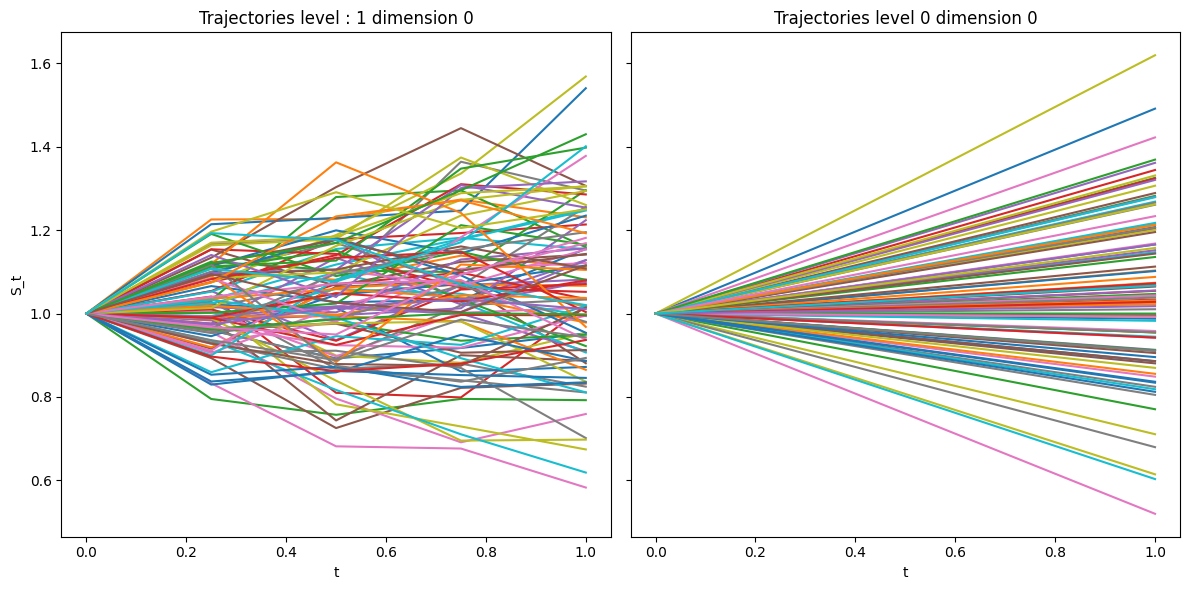

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


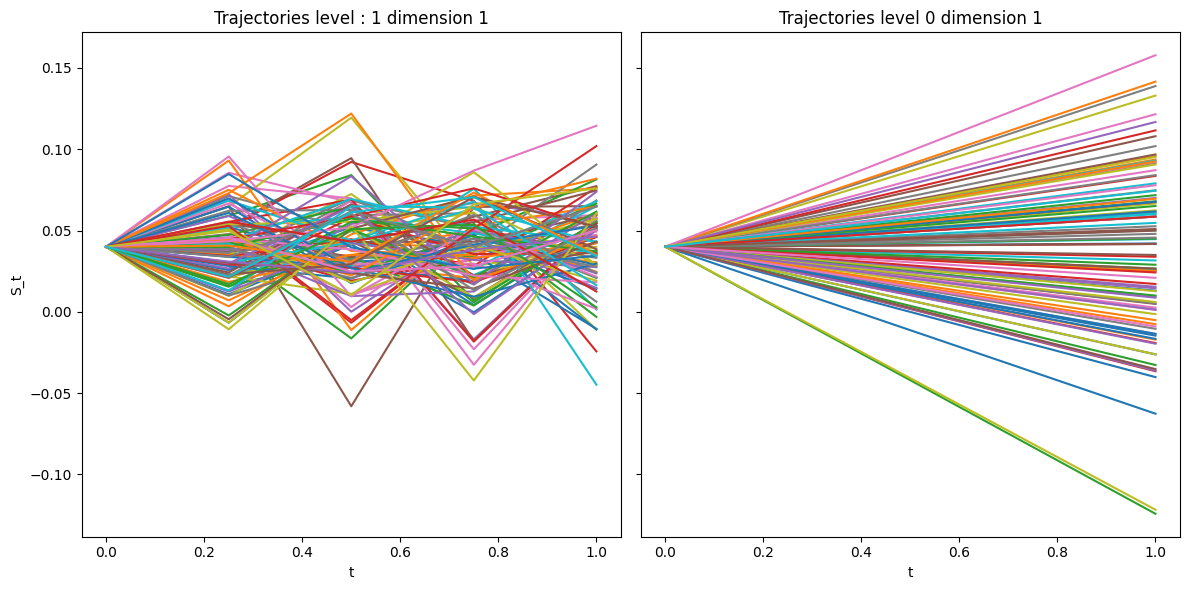

Optimal Nl : [580. 119.]
level : 2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


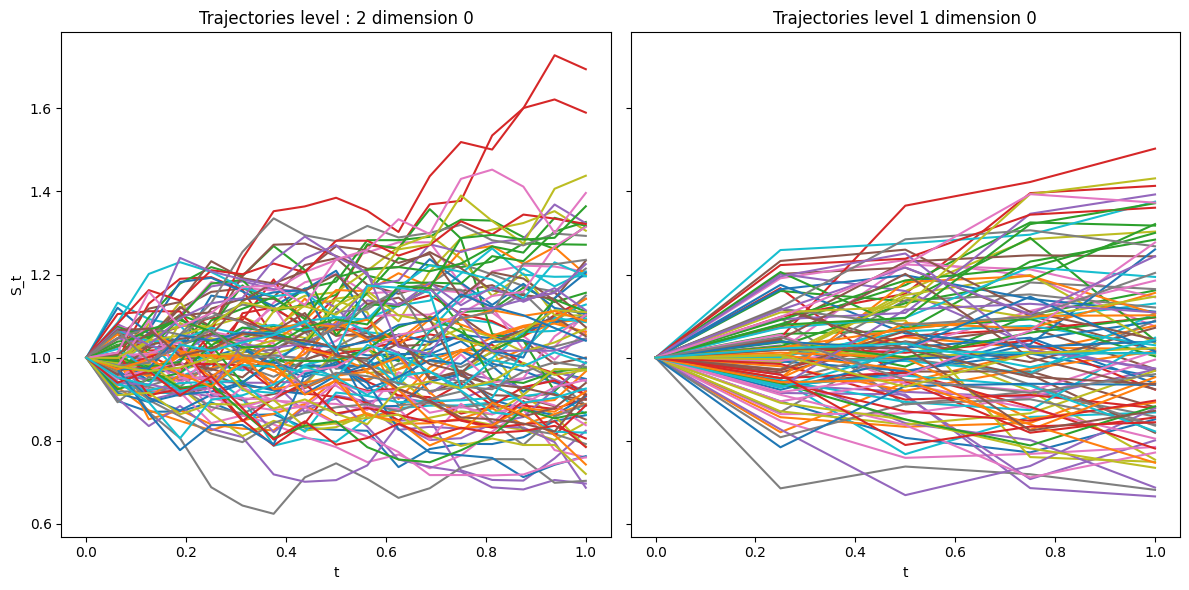

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


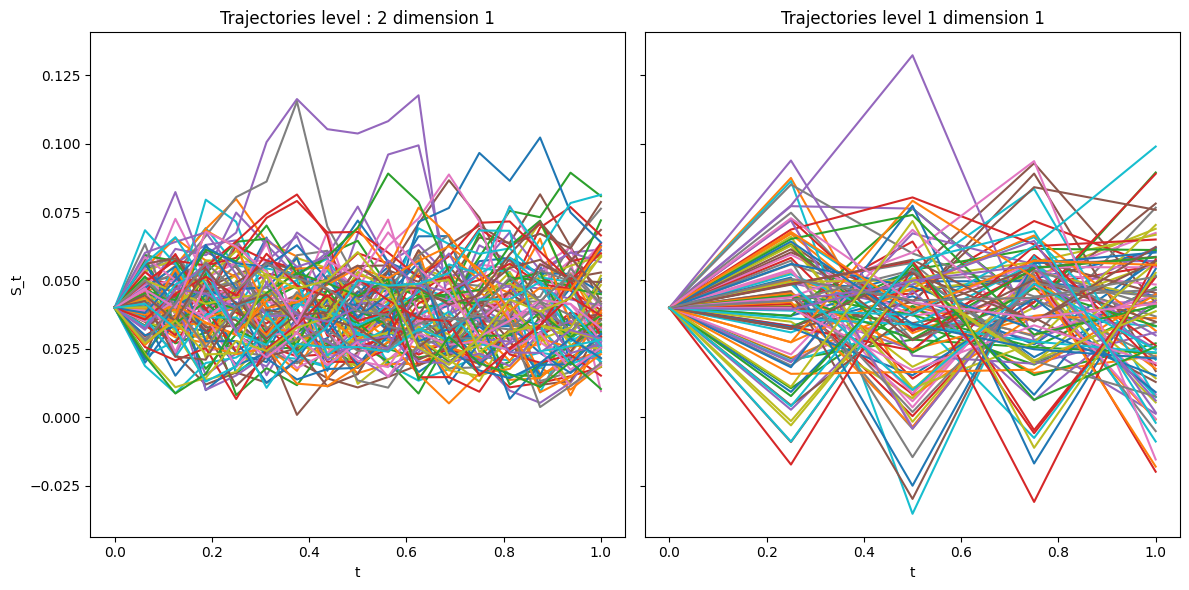

Optimal Nl : [1072.  219.  104.]
convergence test : 
error (should be smaller than target error :  0.01) : 0.0005550161034295445
mean(Y0, ..., YL) = [ 0.10001745  0.00228032 -0.00117737]
var(Y0, ... YL) = [0.015969562718445, 0.002651493914704085, 0.00237085159098659]


0.10112040716737147

In [126]:
# bs = black_sholes(initial_value=np.array([1]),interest_rate=0.05,sigma=0.04)
hesto = heston(initial_value = np.array([1,0.04]),interest_rate = 0.05, sigma = 0.2 ,lambd = 5, ksi = 0.25, rho = -0.5 )
option = call(maturity=1, strike = 1)
mlmc = multilevel_mc_estimator(M=4,max_level=10,N_default=10000,verbose=True,plot_paths=True)
mlmc.compute_mc_estimator(model=hesto,contract=option,target_error=0.01,test_type="10")